[Tutorial](https://pennylane.ai/qml/demos/tutorial_learning_few_data#training-the-qcnn-on-the-digits-dataset)

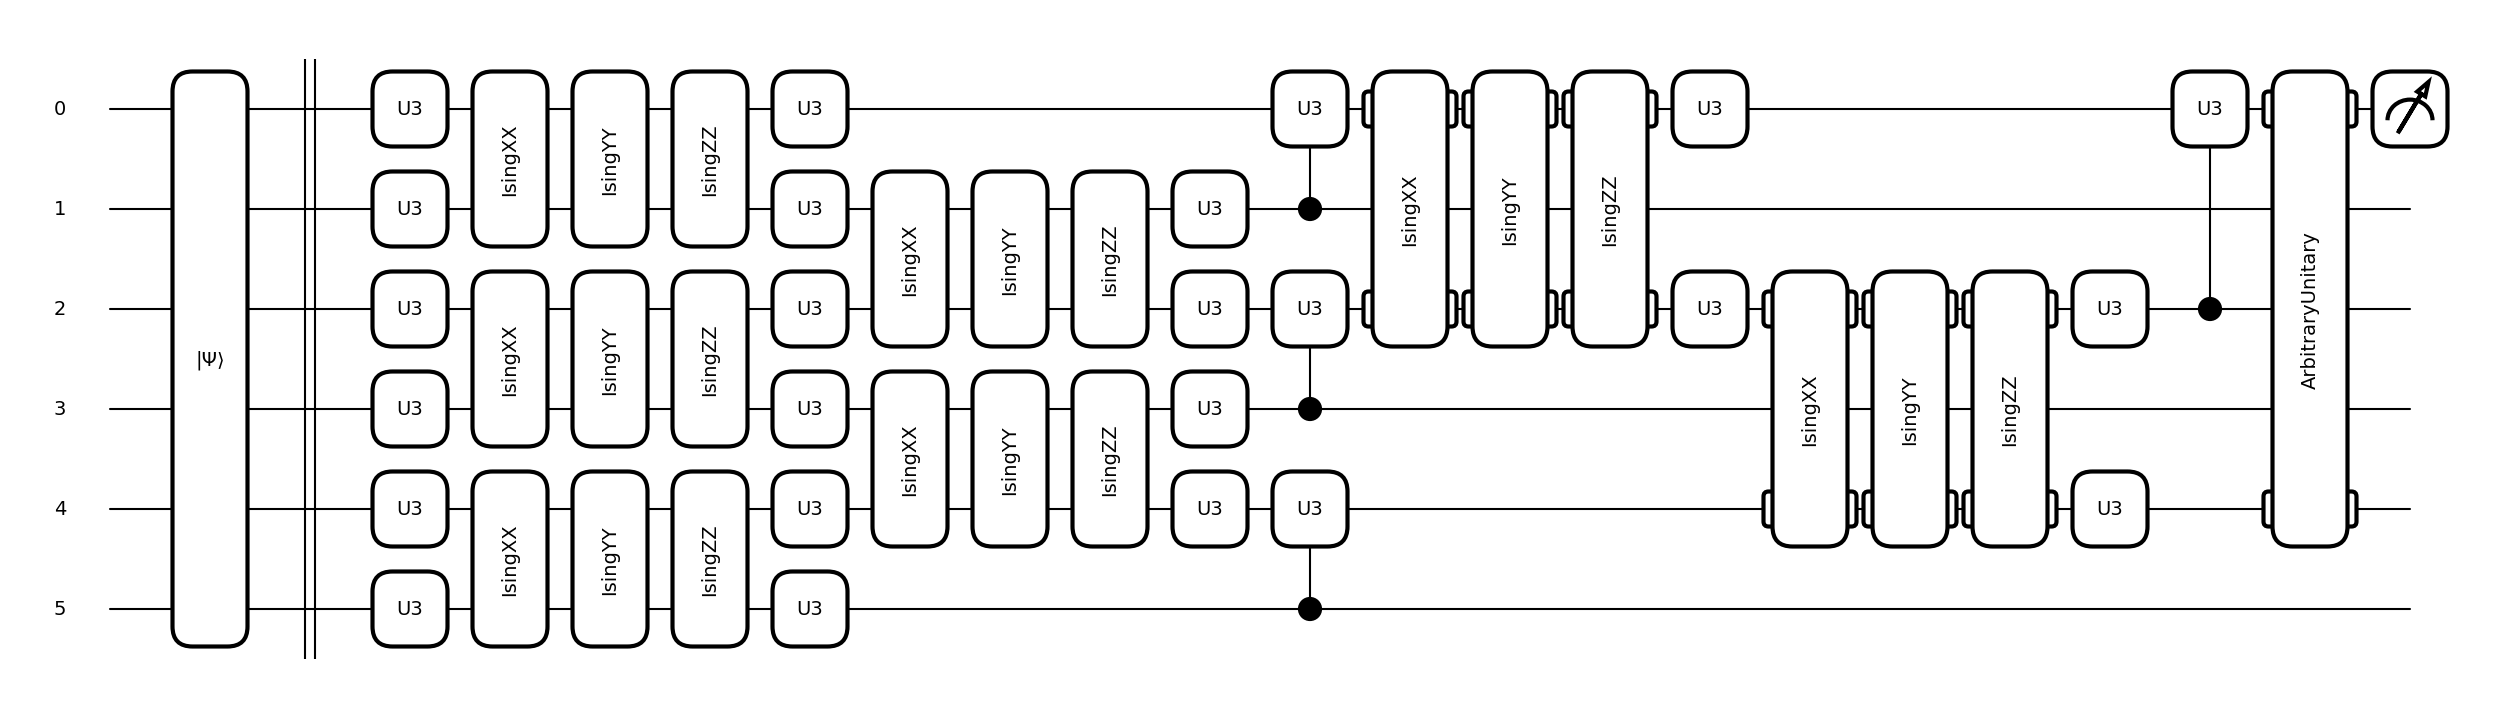

In [2]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax

jax.config.update('jax_platform_name', 'cpu')
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import optax  # optimization using jax

import pennylane as qml
import pennylane.numpy as pnp

from concrete_QCNN import concrete_QCNN

sns.set_theme()

seed = 0
rng = np.random.default_rng(seed=seed)

num_wires = 6
device = qml.device("default.qubit", wires=num_wires)


@qml.qnode(device)
def conv_net(weights, last_layer_weights, features):
    qnn = concrete_QCNN(weights=weights, last_layer_weights=last_layer_weights, input=features)

    return qnn.circuit()

a,b,c = np.random.rand(18, 2), np.random.rand(4 ** 2 - 1), np.random.rand(2 ** num_wires)
c = c / np.linalg.norm(c)
fig, ax = qml.draw_mpl(conv_net)(a,b,c)
# plt.show()
# conv_net(a,b,c)


In [3]:
# digits = datasets.load_digits()
# images, labels = digits.data, digits.target
# images = images[np.where((labels == 0) | (labels == 1))]
# labels = labels[np.where((labels == 0) | (labels == 1))]


def load_digits_data(num_train, num_test, rng):
    """Return training and testing data of digits dataset."""
    digits = datasets.load_digits()
    features, labels = digits.data, digits.target

    # only use first two classes
    features = features[np.where((labels == 0) | (labels == 1))]
    labels = labels[np.where((labels == 0) | (labels == 1))]

    # normalize data
    features = features / np.linalg.norm(features, axis=1).reshape((-1, 1))

    # subsample train and test split
    train_indices = rng.choice(len(labels), num_train, replace=False)
    test_indices = rng.choice(
        np.setdiff1d(range(len(labels)), train_indices), num_test, replace=False
    )

    x_train, y_train = features[train_indices], labels[train_indices]
    x_test, y_test = features[test_indices], labels[test_indices]

    return (
        jnp.asarray(x_train),
        jnp.asarray(y_train),
        jnp.asarray(x_test),
        jnp.asarray(y_test),
    )


@jax.jit
def compute_out(weights, weights_last, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    cost = lambda weights, weights_last, feature, label: conv_net(weights, weights_last, feature)[label]

    return jax.vmap(cost, in_axes=(None, None, 0, 0), out_axes=0)(
        weights, weights_last, features, labels
    )


def compute_accuracy(weights, weights_last, features, labels):
    """Computes the accuracy over the provided features and labels"""
    out = compute_out(weights, weights_last, features, labels)
    return jnp.sum(out > 0.5) / len(out)


def compute_cost(weights, weights_last, features, labels):
    """Computes the cost over the provided features and labels"""
    out = compute_out(weights, weights_last, features, labels)
    return 1.0 - jnp.sum(out) / len(labels)


def init_weights():
    """Initializes random weights for the QCNN model."""
    weights = pnp.random.normal(loc=0, scale=1, size=(18, 2), requires_grad=True)
    weights_last = pnp.random.normal(loc=0, scale=1, size=4 ** 2 - 1, requires_grad=True)
    return jnp.array(weights), jnp.array(weights_last)

value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0, 1]))

def train_qcnn(n_train, n_test, n_epochs):
    """
    Args:
        n_train  (int): number of training examples
        n_test   (int): number of test examples
        n_epochs (int): number of training epochs
        desc  (string): displayed string during optimization

    Returns:
        dict: n_train,
        steps,
        train_cost_epochs,
        train_acc_epochs,
        test_cost_epochs,
        test_acc_epochs

    """
    # load data
    x_train, y_train, x_test, y_test = load_digits_data(n_train, n_test, rng)

    # init weights and optimizer
    weights, weights_last = init_weights()

    # learning rate decay
    cosine_decay_scheduler = optax.cosine_decay_schedule(0.1, decay_steps=n_epochs, alpha=0.95)
    optimizer = optax.adam(learning_rate=cosine_decay_scheduler)
    opt_state = optimizer.init((weights, weights_last))

    # data containers
    train_cost_epochs, test_cost_epochs, train_acc_epochs, test_acc_epochs = [], [], [], []

    for step in range(n_epochs):
        # Training step with (adam) optimizer
        train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
        updates, opt_state = optimizer.update(grad_circuit, opt_state)
        weights, weights_last = optax.apply_updates((weights, weights_last), updates)
        train_cost_epochs.append(train_cost)

        # compute accuracy on training data
        train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
        train_acc_epochs.append(train_acc)

        # compute accuracy and cost on testing data
        test_out = compute_out(weights, weights_last, x_test, y_test)
        test_acc = jnp.sum(test_out > 0.5) / len(test_out)
        test_acc_epochs.append(test_acc)
        test_cost = 1.0 - jnp.sum(test_out) / len(test_out)
        test_cost_epochs.append(test_cost)

        if step % 50 == 0 or step == n_epochs - 1:
            print(f'{step}\t {test_acc:.3f} \t {train_acc:.3f}')

    np.save('weights.npy', weights)
    np.save('weights_last.npy', weights_last)
    print("Weights saved'")


    return dict(
        n_train=[n_train] * n_epochs,
        step=np.arange(1, n_epochs + 1, dtype=int),
        train_cost=train_cost_epochs,
        train_acc=train_acc_epochs,
        test_cost=test_cost_epochs,
        test_acc=test_acc_epochs,
    )


def run_iterations(n_train):
    results_df = pd.DataFrame(columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"])

    print(f'\t \t Test_Acc \t Train_Acc')
    results = train_qcnn(n_train=n_train, n_test=n_test, n_epochs=n_epochs)
    results_df = pd.concat([results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True)

    return results_df
    # return results


n_test = 100
n_epochs = 1000
train_size = 80

print(f"Running training for n_train={train_size}")
results_df = pd.DataFrame(columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"])
print(f'\t \t Test_Acc \t Train_Acc')
results = train_qcnn(n_train=80, n_test=n_test, n_epochs=n_epochs)
results_df = pd.concat([results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True)
print('Done')


Running training for n_train=80
	 	 Test_Acc 	 Train_Acc
0	 0.750 	 0.625
50	 0.990 	 0.950
100	 0.990 	 0.950
150	 0.990 	 0.963
200	 1.000 	 0.963
250	 1.000 	 0.963
300	 1.000 	 0.963
350	 1.000 	 0.963
400	 1.000 	 0.975
450	 1.000 	 0.975
500	 1.000 	 0.975
550	 1.000 	 0.975
600	 1.000 	 0.975
650	 1.000 	 0.975
700	 1.000 	 0.975
750	 1.000 	 0.975
800	 1.000 	 0.975
850	 1.000 	 0.975
900	 1.000 	 0.975
950	 1.000 	 0.975
999	 1.000 	 0.975
Weights saved'
Done


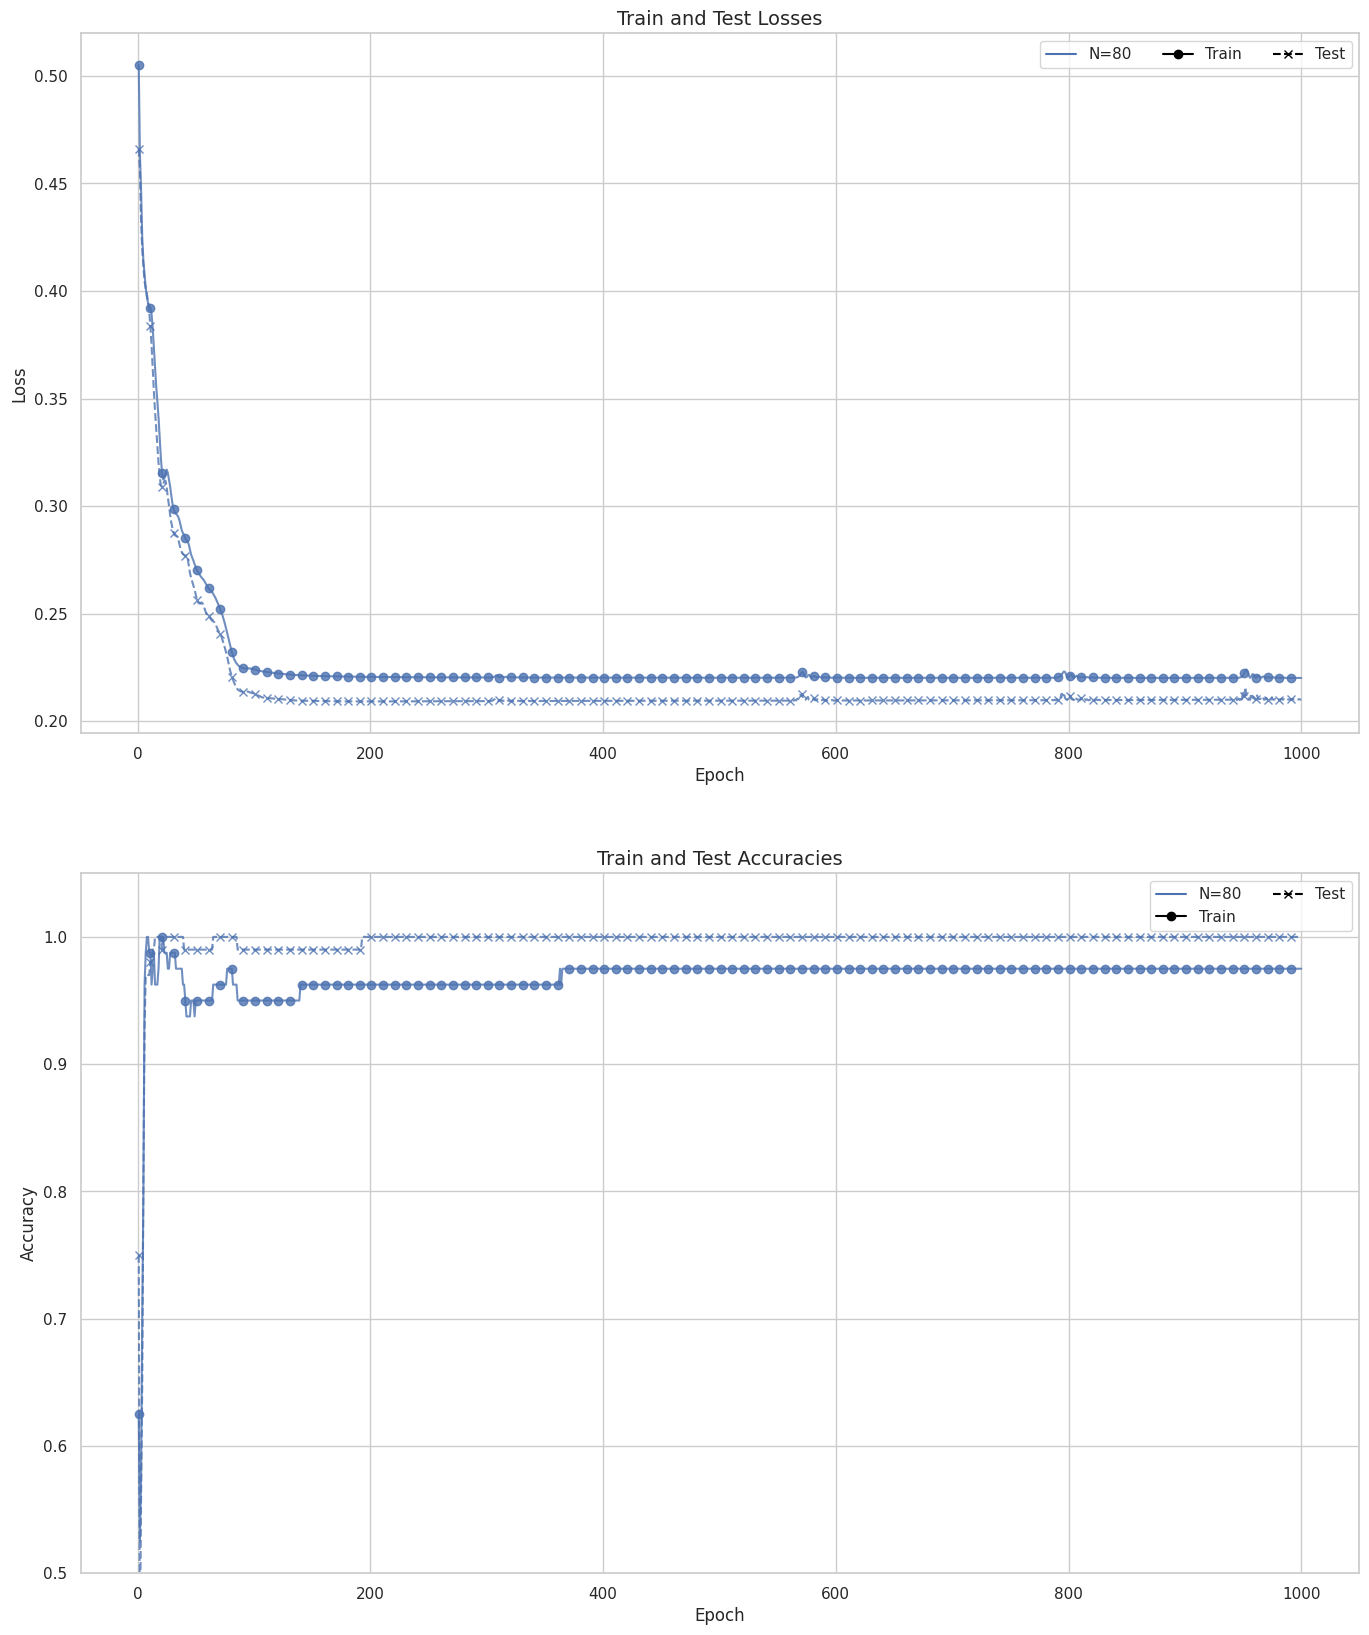

In [4]:
train_sizes = [80]
sns.set_style('whitegrid')
colors = sns.color_palette()
fig, axes = plt.subplots(nrows=2, figsize=(16.5, 20))

generalization_errors = []

# plot losses and accuracies
df_agg = results_df.groupby(["n_train", "step"]).agg(["mean", "std"])
df_agg = df_agg.reset_index()
for i, n_train in enumerate(train_sizes):
    df = df_agg[df_agg.n_train == n_train]

    dfs = [df.train_cost["mean"], df.test_cost["mean"], df.train_acc["mean"], df.test_acc["mean"]]
    lines = ["o-", "x--", "o-", "x--"]
    labels = [fr"$N={n_train}$", None, fr"$N={n_train}$", None]
    axs = [0,0,1,1]

    for k in range(4):
        ax = axes[axs[k]]
        ax.plot(df.step, dfs[k], lines[k], label=labels[k], markevery=10, color=colors[i], alpha=0.8)


    # plot final loss difference
    dif = df[df.step == 100].test_cost["mean"] - df[df.step == 100].train_cost["mean"]
    generalization_errors.append(dif)

# format loss plot
ax = axes[0]
ax.set_title('Train and Test Losses', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')



# format loss plot
ax = axes[1]
ax.set_title('Train and Test Accuracies', fontsize=14)
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0.5, 1.05)

legend_elements = [
    mpl.lines.Line2D([0], [0], label=f'N={n}', color=colors[i]) for i, n in enumerate(train_sizes)
    ] + [
    mpl.lines.Line2D([0], [0], marker='o', ls='-', label='Train', color='Black'),
    mpl.lines.Line2D([0], [0], marker='x', ls='--', label='Test', color='Black')
    ]

axes[0].legend(handles=legend_elements, ncol=3)
axes[1].legend(handles=legend_elements, ncol=2)

# # format generalization error plot
# ax = axes[2]
# ax.plot(train_sizes, generalization_errors, "o-", label=r"$gen(\alpha)$")
# ax.set_xscale('log')
# ax.set_xticks(train_sizes)
# ax.set_xticklabels(train_sizes)
# ax.set_title(r'Generalization Error $gen(\alpha) = R(\alpha) - \hat{R}_N(\alpha)$', fontsize=14)
# ax.set_xlabel('Training Set Size')
# axes[2].set_yscale('log', base=2)
# plt.show()

80 is the best!